## Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pydotplus
from sklearn import tree
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [3]:
train = pd.read_csv('training_ready.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IsBadBuy         72983 non-null  int64  
 1   Auction          72983 non-null  int64  
 2   VehicleAge       72983 non-null  int64  
 3   WheelType        72983 non-null  object 
 4   VehOdo           72983 non-null  int64  
 5   Nationality      72983 non-null  object 
 6   VehBCost         72983 non-null  float64
 7   WarrantyCost     72983 non-null  int64  
 8   OutCost          72983 non-null  int64  
 9   VehOdo_Standard  72983 non-null  float64
 10  AverageMMR       72983 non-null  float64
 11  Make_new         72983 non-null  object 
 12  VNST_new         72983 non-null  object 
 13  Size_class       72983 non-null  int64  
 14  Model_Name       72983 non-null  object 
 15  Model_Property   72983 non-null  object 
 16  SubModel_New     72983 non-null  object 
 17  Trim_New    

In [5]:
#df = train.drop(['Auction','VNST_new', 'Trim', 'Model', 'WheelType', 'VNZIP1'], axis=1)
df = train

In [6]:
df = pd.get_dummies(df, prefix_sep='=')
df.head()

,IsBadBuy,Auction,VehicleAge,VehOdo,VehBCost,WarrantyCost,OutCost,VehOdo_Standard,AverageMMR,Size_class,...,Trim_New=S,Trim_New=SE,Trim_New=SR,Trim_New=SS,Trim_New=ST,Trim_New=SX,Trim_New=T,Trim_New=X,Trim_New=ZX,Trim_New=i
0,0,0,3,89046,7100.0,1113,1,1.448203,10805.00,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,5,93593,7600.0,1053,1,1.423371,9676.50,9,...,0,0,0,0,1,0,0,0,0,0
2,0,0,4,73807,4900.0,1389,1,0.147163,5840.50,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,5,65617,4100.0,630,1,-0.655988,3729.00,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,4,69367,4000.0,1020,1,-0.184597,6349.25,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
X = df[attributes].values
y = df['IsBadBuy']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y)

In [8]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1)

In [10]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None]+ list(np.arange(5, 10 , 1)),
              'min_samples_split': [20, 30, 50, 100],
              'min_samples_leaf': [10, 20, 30, 50, 100],
              'class_weight': [{0:1, 1:round(x,2)} for x in np.arange(3.0, 9.1 , 0.5)],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, 
                                   n_iter=50, cv=5, scoring='f1', random_state=1)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.279 (std: 0.007)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 100, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 7.0}}

Model with rank: 2
Mean validation score: 0.279 (std: 0.004)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 100, 'max_depth': 6, 'criterion': 'gini', 'class_weight': {0: 1, 1: 6.0}}

Model with rank: 3
Mean validation score: 0.276 (std: 0.007)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 7.5}}



In [12]:
clf_1 = DecisionTreeClassifier(min_samples_split= 100, min_samples_leaf= 100, max_depth= 8, 
                               criterion= 'entropy', class_weight= {0: 1, 1: 7.0})
clf_2 = DecisionTreeClassifier(min_samples_split= 30, min_samples_leaf= 100, max_depth= 6, 
                               criterion= 'gini', class_weight= {0: 1, 1: 6.0})
clf_3 = DecisionTreeClassifier(min_samples_split= 100, min_samples_leaf= 20, max_depth= 8, 
                               criterion= 'entropy', class_weight= {0: 1, 1: 7.5})
clf_1.fit(X_train, y_train)
clf_2.fit(X_train, y_train)
clf_3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 7.5},
                       criterion='entropy', max_depth=8, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=100, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [13]:
for col, imp in zip(attributes, clf_1.feature_importances_):
    if imp>0.0:
        print(col, imp)

Auction 0.013999121764447049
VehicleAge 0.44825227225334746
VehOdo 0.061845860911950774
VehBCost 0.1967070875980426
WarrantyCost 0.023009225337568537
VehOdo_Standard 0.024024082978521214
AverageMMR 0.05579388851666
Size_class 0.0010431985358227954
WheelType=Alloy 0.0048175337886068575
WheelType=Covers 0.017397917017104872
Make_new=FORD 0.005081198649944599
Make_new=NISSAN 0.0036259638723237374
Make_new=TOYOTA 0.004274608810495923
VNST_new=CO 0.002488876091676969
VNST_new=FL 0.007198803073845175
VNST_new=NC 0.002368698457266955
Model_Name=EXPLORER 0.01575522030703795
Model_Name=IMPALA 0.02961897857763749
Model_Name=MALIBU 0.008640505989833461
Model_Property=2WD 0.004289777945954711
Model_Property=4C 0.005832880239707683
Model_Property=CRUISER 0.007401462571075609
Model_Property=V6 0.020109505994796877
SubModel_New=SEDAN 0.005284289175671548
SubModel_New=WAGON 0.008336810178309069
Trim_New=Bas 0.0064854561285343885
Trim_New=S 0.0018974471863238656
Trim_New=SE 0.011798807016325751
Trim_Ne

In [14]:
y_pred = clf_1.predict(X_test)
y_pred_tr = clf_1.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print(confusion_matrix(y_train, y_pred_tr))
print()
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.598555433761353
Train F1-score [0.71957339 0.29379154]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     44805
           1       0.19      0.68      0.29      6283

    accuracy                           0.60     51088
   macro avg       0.56      0.63      0.51     51088
weighted avg       0.84      0.60      0.67     51088

[[26313 18492]
 [ 2017  4266]]


Test Accuracy 0.5868463119433661
Test F1-score [0.71141453 0.27306332]
              precision    recall  f1-score   support

           0       0.92      0.58      0.71     19202
           1       0.17      0.63      0.27      2693

    accuracy                           0.59     21895
   macro avg       0.55      0.61      0.49     21895
weighted avg       0.83      0.59      0.66     21895



array([[11150,  8052],
       [  994,  1699]], dtype=int64)

In [15]:
y_pred = clf_2.predict(X_test)
y_pred_tr = clf_2.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print(confusion_matrix(y_train, y_pred_tr))
print()
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.6920216097713748
Train F1-score [0.80299995 0.29469249]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80     44805
           1       0.21      0.52      0.29      6283

    accuracy                           0.69     51088
   macro avg       0.56      0.62      0.55     51088
weighted avg       0.83      0.69      0.74     51088

[[32067 12738]
 [ 2996  3287]]


Test Accuracy 0.681662480018269
Test F1-score [0.7962584  0.27244259]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80     19202
           1       0.19      0.48      0.27      2693

    accuracy                           0.68     21895
   macro avg       0.55      0.60      0.53     21895
weighted avg       0.82      0.68      0.73     21895



array([[13620,  5582],
       [ 1388,  1305]], dtype=int64)

In [16]:
y_pred = clf_3.predict(X_test)
y_pred_tr = clf_3.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print(confusion_matrix(y_train, y_pred_tr))
print()
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.5739899780770436
Train F1-score [0.69578709 0.28954756]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70     44805
           1       0.18      0.71      0.29      6283

    accuracy                           0.57     51088
   macro avg       0.56      0.63      0.49     51088
weighted avg       0.84      0.57      0.65     51088

[[24889 19916]
 [ 1848  4435]]


Test Accuracy 0.5624115094770495
Test F1-score [0.6873756  0.27101879]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69     19202
           1       0.17      0.66      0.27      2693

    accuracy                           0.56     21895
   macro avg       0.55      0.60      0.48     21895
weighted avg       0.83      0.56      0.64     21895



array([[10533,  8669],
       [  912,  1781]], dtype=int64)

In [18]:
y_pred1 = clf_1.predict(X_test)
y_pred3 = clf_3.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred1))
print('Test F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print()
print()
print('Test Accuracy %s' % accuracy_score(y_test, y_pred3))
print('Test F1-score %s' % f1_score(y_test, y_pred3, average=None))
print(classification_report(y_test, y_pred3))
confusion_matrix(y_test, y_pred3)

Test Accuracy 0.5868463119433661
Test F1-score [0.71141453 0.27306332]
              precision    recall  f1-score   support

           0       0.92      0.58      0.71     19202
           1       0.17      0.63      0.27      2693

    accuracy                           0.59     21895
   macro avg       0.55      0.61      0.49     21895
weighted avg       0.83      0.59      0.66     21895

[[11150  8052]
 [  994  1699]]


Test Accuracy 0.5624115094770495
Test F1-score [0.6873756  0.27101879]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69     19202
           1       0.17      0.66      0.27      2693

    accuracy                           0.56     21895
   macro avg       0.55      0.60      0.48     21895
weighted avg       0.83      0.56      0.64     21895



array([[10533,  8669],
       [  912,  1781]], dtype=int64)

Scegliamo il primo modello (clf_1)

In [19]:
classes = clf_1.classes_.astype(str)
classes

array(['0', '1'], dtype='<U21')

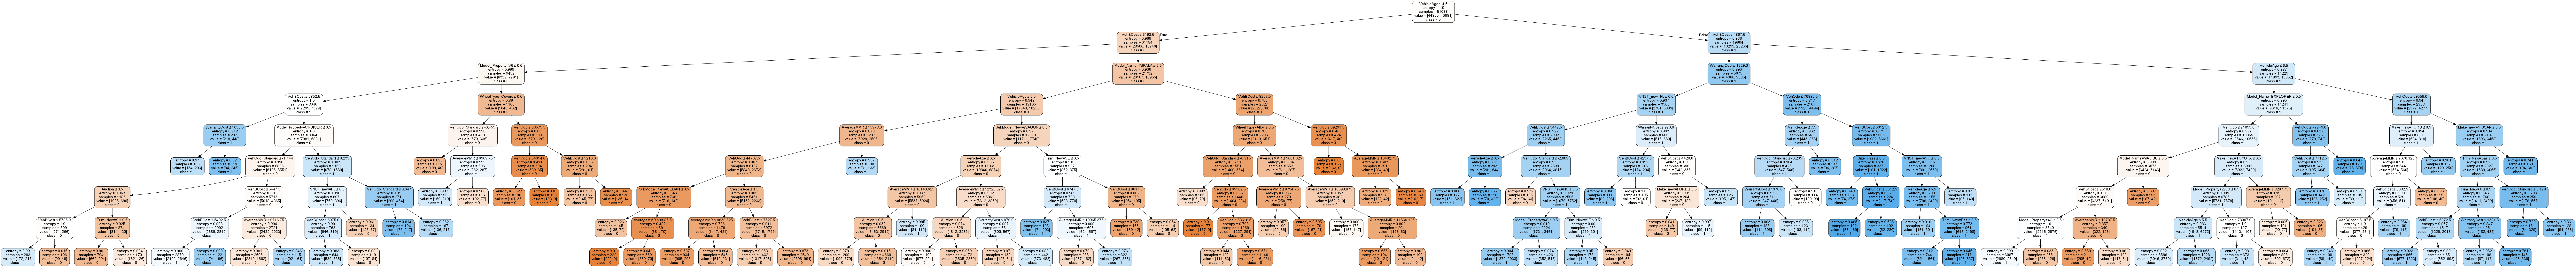

In [20]:
dot_data = tree.export_graphviz(clf_1, out_file=None,  
                                feature_names=attributes, 
                                class_names=classes,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

roc: 0.60578
gini: 0.21156


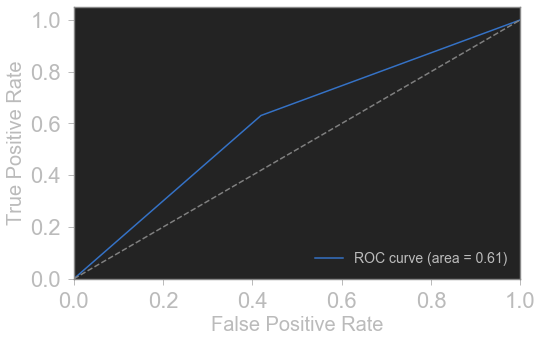

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
gini=2*roc_auc-1
print('roc:',round(roc_auc,5))
print('gini:',round(gini,5))

roc_auc = roc_auc_score(y_test, y_pred1, average=None)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## Random Forest

Applichiamo un algoritmo Random Forest a partire dal migliore albero decisionale ottenuto in precedenza.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserW

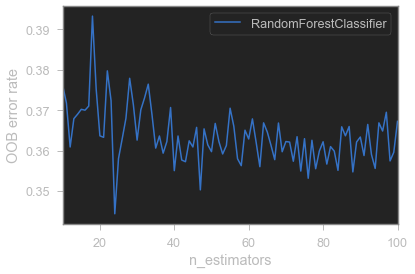

In [30]:
ensemble_clfs = [ ("RandomForestClassifier",RandomForestClassifier(min_samples_split= 100, min_samples_leaf= 100, max_depth= 8, 
                               criterion= 'entropy', class_weight= {0: 1, 1: 7.0}, oob_score=True))]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 10
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

All'aumentare degli alberi, diminuisce la varianza dell'errore (dopo circa 60 alberi sembra stabilizzarsi).

C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserW

C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\ensemble\_forest.py:523: UserW

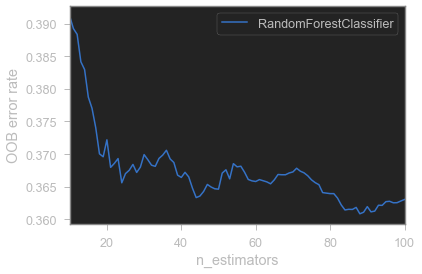

In [36]:
ensemble_clfs = [ ("RandomForestClassifier",RandomForestClassifier(min_samples_split= 100, min_samples_leaf= 100, max_depth= 8, 
                                            criterion= 'entropy', class_weight= {0: 1, 1: 7.0}, 
                                            oob_score=True, warm_start=True, random_state=10))]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 10
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

scegliamo 90 alberi

In [10]:
rf = RandomForestClassifier(min_samples_split= 100, min_samples_leaf= 100, max_depth= 8, 
                            criterion= 'entropy', class_weight= {0: 1, 1: 7.25}, 
                            oob_score=True, warm_start=True, random_state=10, n_estimators=90)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 7.25}, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=100, min_weight_fraction_leaf=0.0,
                       n_estimators=90, n_jobs=None, oob_score=True,
                       random_state=10, verbose=0, warm_start=True)

In [10]:
y_pred = rf.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Test Accuracy 0.6143868463119434
Test F1-score [0.73553641 0.28841129]
              precision    recall  f1-score   support

           0       0.92      0.61      0.74     19202
           1       0.19      0.64      0.29      2693

    accuracy                           0.61     21895
   macro avg       0.55      0.62      0.51     21895
weighted avg       0.83      0.61      0.68     21895



array([[11741,  7461],
       [  982,  1711]], dtype=int64)

In [13]:
y_pred = rf.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Test Accuracy 0.6143868463119434
Test F1-score [0.73553641 0.28841129]
              precision    recall  f1-score   support

           0       0.92      0.61      0.74     19202
           1       0.19      0.64      0.29      2693

    accuracy                           0.61     21895
   macro avg       0.55      0.62      0.51     21895
weighted avg       0.83      0.61      0.68     21895



array([[11741,  7461],
       [  982,  1711]], dtype=int64)

roc: 0.6234
gini: 0.2468


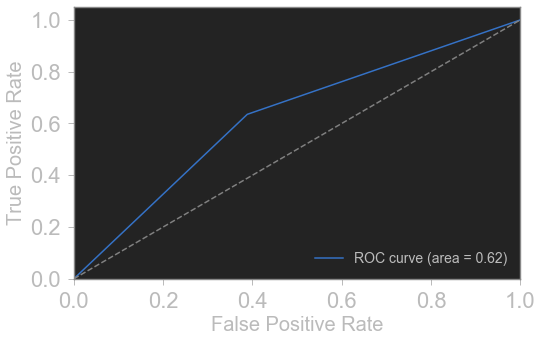

In [54]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
gini=2*roc_auc-1
print('roc:',round(roc_auc,5))
print('gini:',round(gini,5))

roc_auc = roc_auc_score(y_test, y_pred, average=None)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

C:\Users\basil\Anaconda3\envs\BDASM\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


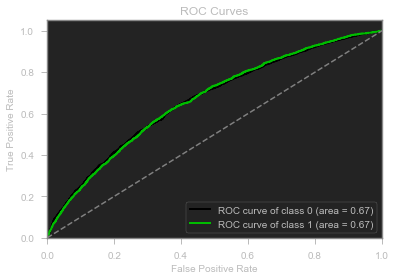

In [61]:
import scikitplot as skplt
y_proba = rf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_proba, curves='each_class')
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.show()

In [16]:
vimp = []
for col, imp in zip(attributes, rf.feature_importances_):
    if imp >= 0.01:
        vimp.append([col, round(imp,3)])
v_df = pd.DataFrame(data=vimp, columns=['Variable','Importance'])
v_df.set_index(['Variable'], inplace=True)
v_df = v_df.sort_values(by="Importance", ascending=False)
v_df

,Importance
Variable,
VehicleAge,0.178
VehBCost,0.155
AverageMMR,0.127
VehOdo,0.078
WarrantyCost,0.053
VehOdo_Standard,0.038
Trim_New=L,0.024
Size_class,0.021
WheelType=Covers,0.021


Text(0.5, 1.0, 'Variable importance')

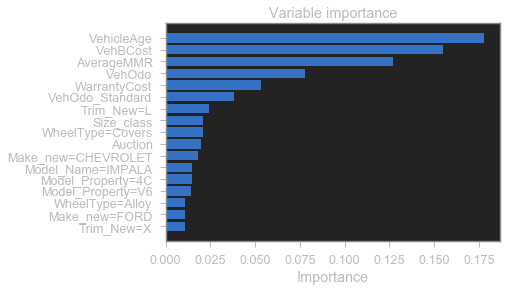

In [20]:
fig, ax = plt.subplots()

ax.barh(v_df.index, v_df['Importance'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Variable importance')
